# A soft module approach to modelling the MAPK cascade
In typical bond graph approaches to hierarchical modelling (and also in many computational models seen in engineering and programming), modules are specified through the use of hard ports which are unable to be changed after the development of a model. However, in systems biology, researchers are increasingly favouring the use of a "soft port" approach in which ports are flexible, and ports can be exposed during the process of coupling models together. This approach requires a shift away from the "black-box" modularity commonly seen in engineering, and requires the internal details of a model to be externally accessible. Examples of this approach are seen in the *little b* and PySB software packages among others, but the scope of these packages are often limited to kinetic models of biochemical systems (which are often thermodynamically inconsistent). Up until recently, an equivalent approach was not available through the use of bond graphs. However, the development of BondGraphTools has enabled a soft module approach to be taken.

In this notebook, a model of the MAPK cascade is constructed using the idea of soft modules to demonstrate the feasibility of this approach using bond graphs. It will be shown that this approach has the following implications:
- At each point in the hierarchy, individual models are able to be independently simulated.
- The code explicitly records the components that are merged together.
- Submodules are able to be assigned attributes that contain information about them. From a programming point of view, this can be useful in accessing information that summarises how modules are constructed. From a model development perspective, these attributes can also be used to store potentially important information such as biological annotations or the provenance of a model.
- A model's parameters can be inherited from its submodules. This means that parameters only need to be specified once, provided that none of the parameters conflict with each other. In the case where components with different parameters are merged, the modeller needs to decide how to resolve the conflict. However, the resulting parameter assignment is made explicit. A potential disadvantage of this approach is that the code required to describe parameter inheritance adds some overhead to the development of small models.
- Classes of models with similar (but not identical) structures can be automatically constructed.
- An implication of this approach not discussed here is that is is straightforward to make incremental changes to existing models. Furthermore, the changes are explicitly documented within the code, which may make recording model provenance easier.

In [ ]:
# This block of code is used to make the notebook work within Binder.
# It can be skipped or deleted for most other setups.
import julia
from julia import Julia
jl = Julia(compiled_modules=False)

In [1]:
import BondGraphTools as bgt
from BondGraphTools import BondGraph
import numpy as np
from matplotlib import pyplot as plt

import sys
import bgt_extensions as bgex
from bgt_extensions import Ce, Se, unify, promote
from general import mpl_settings, save_figure
from plot_options import set_color_palette
set_color_palette()

## Kinase
Below, a generic model of a kinase is constructed. The model contains the reaction network
$$
\begin{align}
E + M + ATP \rightleftharpoons C \\
C \rightleftharpoons E + MP + ADP
\end{align}
$$
ATP and ADP are considered chemostats in this model.

Note that in this notebook, models are constructed using programming classes rather than functions. This is useful as it allows models to be assigned arbitrary attributes. In the example below, the class is used to describe the default parameters of the model (which can later be inherited by models that use it).

In [4]:
affinity_ATP_hydrolysis = 50000/8.314/310

class Kinase(BondGraph):
    def __init__(self,name="Kinase",K_M=1.0,K_E=1.0):
        kinase_reactions = [
            ("E + M + ATP = C","r1"),
            ("C = E + MP + ADP","r2")
        ]
        chemostats = ["ATP","ADP"]
        self.K_M = K_M
        self.K_E = K_E
        
        BondGraph.__init__(self,name=name)
        bgex.add_reactions(self,kinase_reactions,chemostats,normalised=True)
        
    @property
    def default_params(self):
        self.ATP_potential = affinity_ATP_hydrolysis
        self.ADP_potential = 0.0
        ATP_potential = self.ATP_potential
        
        a = 1000
        d = 150
        k = 150
        
        D = (a*k/d)**2*np.exp(-affinity_ATP_hydrolysis)
        P_factor = (np.sqrt(D)/k)*(d/a)*np.exp(affinity_ATP_hydrolysis)
        
        K_C = np.exp(ATP_potential)*d/a*self.K_M*self.K_E
        K_MP = self.K_M*P_factor
        r1 = d/K_C
        r2 = k/K_C
        
        params = {
            ("C:E","k"): self.K_E,
            ("C:C","k"): K_C,
            ("C:M","k"): self.K_M,
            ("C:MP","k"): K_MP,
            ("SS:ATP","e"): ATP_potential,
            ("SS:ADP","e"): self.ADP_potential,
            ("R:r1","r"): r1,
            ("R:r2","r"): r2
        }
        
        return params
        
    def set_params(self, params=None):
        if not params:
            params = self.default_params
        bgex.set_parameters(self,params)

An instance of the kinase is built below. Note that the kinase has a set of differential equations, and can therefore be simulated independently of any external inputs.

[dx_0 + 1000*x_0*x_1 + 612882032400059*x_0*x_3/10000000000000000 - 300*x_2,
 dx_1 + 1000*x_0*x_1 - 150*x_2,
 dx_2 - 1000*x_0*x_1 - 612882032400059*x_0*x_3/10000000000000000 + 300*x_2,
 dx_3 + 612882032400059*x_0*x_3/10000000000000000 - 150*x_2]

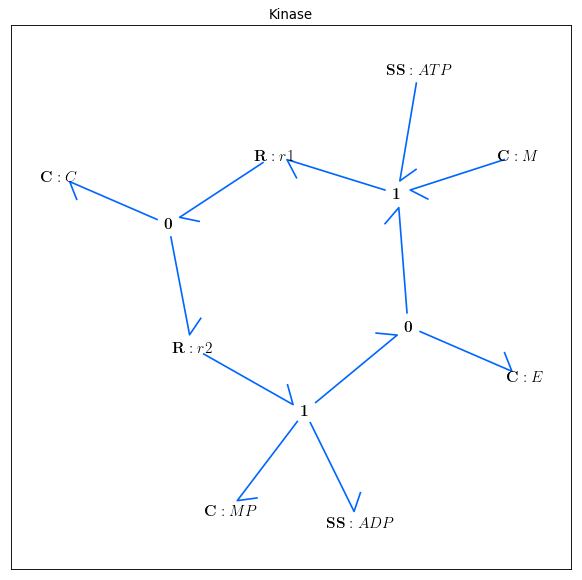

In [5]:
model = Kinase()
model.set_params()
bgt.draw(model)
model.constitutive_relations

The default parameters of the model can be accessed using the code below:

In [7]:
model.default_params

{('C:E', 'k'): 1.0,
 ('C:C', 'k'): 39933509.573638074,
 ('C:M', 'k'): 1.0,
 ('C:MP', 'k'): 16316.353672239,
 ('SS:ATP', 'e'): 19.39984635321688,
 ('SS:ADP', 'e'): 0.0,
 ('R:r1', 'r'): 3.7562438563882655e-06,
 ('R:r2', 'r'): 3.7562438563882655e-06}

## Phosphatase
A similar approach can be taken for the phosphatase, with the reaction scheme
$$
\begin{align}
E + MP \rightleftharpoons C \\
C \rightleftharpoons E + M + P
\end{align}
$$
where P is considered to be a chemostat.

In [12]:
class Phosphatase(BondGraph):
    def __init__(self,name="Phosphatase",K_MP=1.0,K_E=1.0):
        phosphatase_reactions = [
            ("E + MP = C","r1"),
            ("C = E + M + P","r2")
        ]
        chemostats = ["P"]
        self.K_MP = K_MP
        self.K_E = K_E
        
        BondGraph.__init__(self,name=name)
        bgex.add_reactions(self,phosphatase_reactions,chemostats,normalised=True)
        
    @property
    def default_params(self):
        self.P_potential = 0.0
        
        a = 1000
        d = 150
        k = 150
        
        D = (a*k/d)**2*np.exp(-affinity_ATP_hydrolysis)
        P_factor = (np.sqrt(D)/k)*(d/a)*np.exp(affinity_ATP_hydrolysis)
        
        K_C = d/a*self.K_MP*self.K_E
        K_M = self.K_MP/P_factor
        r1 = d/K_C
        r2 = k/K_C
        
        params = {
            ("C:E","k"): self.K_E,
            ("C:C","k"): K_C,
            ("C:M","k"): K_M,
            ("C:MP","k"): self.K_MP,
            ("SS:P","e"): self.P_potential,
            ("R:r1","r"): r1,
            ("R:r2","r"): r2
        }
        return params
        
    def set_params(self,params=None):
        self.P_potential = -5.0
        if not params:
            params = self.default_params
        bgex.set_parameters(self,params)

[dx_0 + 1000*x_0*x_1 + 612882032400059*x_0*x_3/10000000000000000 - 300*x_2,
 dx_1 + 1000*x_0*x_1 - 150*x_2,
 dx_2 - 1000*x_0*x_1 - 612882032400059*x_0*x_3/10000000000000000 + 300*x_2,
 dx_3 + 612882032400059*x_0*x_3/10000000000000000 - 150*x_2]

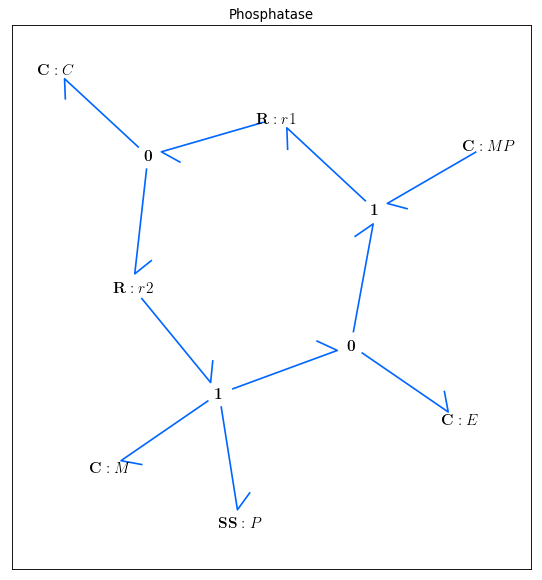

In [13]:
model = Phosphatase()
model.set_params()
bgt.draw(model)
model.constitutive_relations

## Phosphorylation cycle
The kinase and phosphatase models are combined to make a model of the phosphorylation cycle. The code below describes the set of actions required to construct a model of the phosphorylation cycle:
- The kinase and phosphatase are imported into a model of the phosphorylation cycle
- The unphosphorylated substrates M and phosphorylated MP are shared between both modules. Therefore they are "unified" in the model of the phosphorylation cycle, i.e. the bonds that originally connected those components are exposed, and linked to a single unified component through a zero junction that sums their rates of accumulation.
- Because the merging of M and MP combined two components into one, we need to decide how to assign parameters for the merged component. In this case, the parameters were identical in the submodules, so the parameter was taken from the kinase model in both cases.
- The parameters for the other components can be directly inherited from the kinase or phosphatase modules.

In [15]:
class PhosphorylationCycle(BondGraph):
    def __init__(self,name="Phosphorylation Cycle",K_M=1.0,K_MP=1.0,K_Kin=1.0):
        k = Kinase(K_M=K_M,K_E=K_Kin)
        p = Phosphatase(K_MP=K_MP)
        BondGraph.__init__(self,name=name,components=(k,p))
        
        self.kinase = k
        self.phosphatase = p
        self.K_M = K_M
        self.K_MP = K_MP
        self.K_Kin = K_Kin
        
        M = unify((k/"C:M",p/"C:M"),"M")[0]
        MP = unify((k/"C:MP",p/"C:MP"),"MP")[0]
        
        bgex.set_aqueous_solution_parameters(self,R=1.0,T=1.0)
        
    @property
    def default_params(self):
        params = {
            ("C:M","k"): self.kinase.default_params[("C:M","k")],
            ("C:MP","k"): self.kinase.default_params[("C:MP","k")],
        }
        
        return params
        
    def set_params(self, params=None):
        (self.kinase).set_params()
        (self.phosphatase).set_params()
        
        if not params:
            params = self.default_params
        bgex.set_parameters(self,params)

[dx_0 + 1000*x_0*x_4 + 306441016200029*x_0*x_5/5000000000000000 - 300*x_1,
 dx_1 - 1000*x_0*x_4 - 306441016200029*x_0*x_5/5000000000000000 + 300*x_1,
 dx_2 + 1000*x_2*x_4 + 16316353672239*x_2*x_5/1000000 - 300*x_3,
 dx_3 - 1000*x_2*x_4 - 16316353672239*x_2*x_5/1000000 + 300*x_3,
 dx_4 + 1000*x_0*x_4 - 150*x_1 + 1000*x_2*x_4 - 150*x_3,
 dx_5 + 306441016200029*x_0*x_5/5000000000000000 - 150*x_1 + 16316353672239*x_2*x_5/1000000 - 150*x_3]

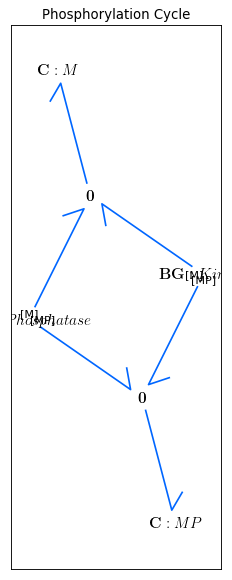

In [16]:
model = PhosphorylationCycle()
model.set_params()
bgt.draw(model)
model.constitutive_relations

## Multisite phosphorylation
Individual "levels" of the MAPK cascade can be interpreted in terms of the number of sites of phosphorylation. For example in the model used in Huang and Ferrell (1996; doi: 10.1073/pnas.93.19.10078), the activation of MAPKKK requires only a single phosphorylation event. However, both MAPKK and MAPK contain two phosphorylation sites that need to be sequentially phosphorylated for those substrates to become active, and thus the activation of those substrates can be interpreted as dual phosphorylation cycles. More generally, substrates can have an arbitrary number of phosphorylation sites (and increasing the number of phosphorylation sites has been thought to increase the ultrasensitivity of the cascade), thus it is useful to have a general constructor for phosphorylation chains of arbitrary length. The code below implements such a constructor.

In [18]:
a = 1000
d = 150
k = 150
D = (a*k/d)**2*np.exp(-affinity_ATP_hydrolysis)
P_factor_default = (np.sqrt(D)/k)*(d/a)*np.exp(affinity_ATP_hydrolysis)

class MultisitePhosphorylation(BondGraph):
    def __init__(self,n,name=None,K_M=1.0,P_factor=P_factor_default,K_Kin=1.0):
        self.n = n
        if not name:
            name=f"{n}-site phosphorylation"
            
        K_array = [K_M*P_factor**i for i in range(n+1)]        
        cycles = tuple(
            PhosphorylationCycle(name=f"Step {i+1}",
                                 K_M=K_array[i],K_MP=K_array[i+1],K_Kin=K_Kin) 
            for i in range(n)
        )
        self.cycles = cycles
        BondGraph.__init__(self,name=name,components=cycles)
        
        # Merge substrates
        promote(cycles[0]/"C:M")
        end_species = cycles[-1]/"C:MP"
        promote(end_species)
        end_species.name = "M"+"P"*n
        
        for i in range(n-1):
            unify((cycles[i]/"C:MP",cycles[i+1]/"C:M"),"M"+"P"*(i+1))
            
        ATP_components = tuple(cycle.kinase/"SS:ATP" for cycle in cycles)
        ADP_components = tuple(cycle.kinase/"SS:ADP" for cycle in cycles)
        P_components = tuple(cycle.phosphatase/"SS:P" for cycle in cycles)
        equivalent_components = [
            (ATP_components, "ATP"),
            (ADP_components, "ADP"),
            (P_components, "P"),
        ]
        for components,species in equivalent_components:
            for comp in components:
                promote(comp)
            unify(components,species)
        
        # Merge kinases
        kinase_enzymes = tuple(c/"Kinase"/"C:E" for c in cycles)
        for i,s in enumerate(kinase_enzymes):
            promote(s)
            s.name = "Kin"
        unify(kinase_enzymes,"Kin")
        
        # Merge phosphatases
        phosphatase_enzymes = tuple(c/"Phosphatase"/"C:E" for c in cycles)
        for s in phosphatase_enzymes:
            promote(s)
            s.name = "Pho"
        unify(phosphatase_enzymes,"Pho")
        
        bgex.set_aqueous_solution_parameters(self,R=1.0,T=1.0)
        
    @property
    def default_params(self):
        cycles = self.cycles
        cycle1 = cycles[0]
        kinase1 = cycle1.kinase
        phosphatase1 = cycle1.phosphatase
        params = {
            ("C:Kin","k"): kinase1.default_params[("C:E","k")],
            ("C:Pho","k"): phosphatase1.default_params[("C:E","k")],
            ("SS:ATP","e"): kinase1.default_params[("SS:ATP","e")],
            ("SS:ADP","e"): kinase1.default_params[("SS:ADP","e")],
            ("SS:P","e"): phosphatase1.default_params[("SS:P","e")],
        }
        
        for i in range(self.n):
            phosphates = "P"*i
            params[(f"C:M{phosphates}","k")] = cycles[i].default_params[("C:M","k")]
        
        phosphates = "P"*(self.n)
        params[(f"C:M{phosphates}","k")] = cycles[-1].default_params[("C:MP","k")]
        return params
    
    def set_params(self, params=None):
        for c in self.cycles:
            c.set_params()
            
        if not params:
            params = self.default_params
        bgex.set_parameters(self,params)

A phosphorylation chain of length 1 is equivalent to the phosphorylation cycle seen in the above section. However, for convenience, many components (M, MP, ATP, ADP, P, kinase enzyme, phosphatase enzyme) have been exposed a level up in the model hierarchy.

[dx_0 + 300*x_0 - 1000*x_2*x_4 - 306441016200029*x_3*x_4/5000000000000000,
 dx_1 + 300*x_1 - 612882032400059*x_2*x_5/10000000000000000 - 1000*x_3*x_5,
 dx_2 - 150*x_0 - 150*x_1 + 1000*x_2*x_4 + 612882032400059*x_2*x_5/10000000000000000,
 dx_3 - 150*x_0 - 150*x_1 + 306441016200029*x_3*x_4/5000000000000000 + 1000*x_3*x_5,
 dx_4 - 300*x_0 + 1000*x_2*x_4 + 306441016200029*x_3*x_4/5000000000000000,
 dx_5 - 300*x_1 + 612882032400059*x_2*x_5/10000000000000000 + 1000*x_3*x_5]

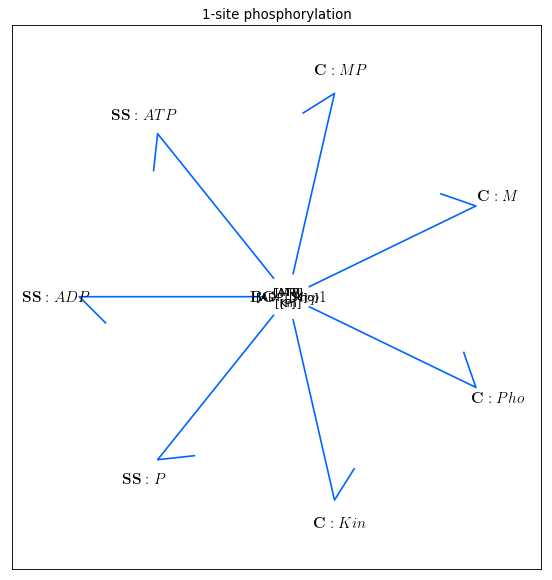

In [19]:
model = MultisitePhosphorylation(n=1)
model.set_params()
bgt.draw(model)
model.constitutive_relations

The code is easily modified to create a phosphorylation chain of length 2. Note that in this case, the following components need to be merged:
- ATP, ADP and P need to be shared between cycles
- The species with a single phosphorylated site needs to be shared between phosphorylation cycles
- It is generally assumed that the same kinase/phosphatase is responsible for all phosphorylation/dephosphorylation events in the chain. Therefore these need to be merged as well.

[dx_0 + 300*x_0 - 1000*x_4*x_7 - 306441016200029*x_6*x_7/5000000000000000,
 dx_1 + 300*x_1 - 612882032400059*x_4*x_8/10000000000000000 - 1000*x_6*x_8,
 dx_2 + 300*x_2 - 306441016200029*x_5*x_7/5000000000000000 - 1000*x_6*x_7,
 dx_3 + 300*x_3 - 1000*x_5*x_8 - 612882032400059*x_6*x_8/10000000000000000,
 dx_4 - 150*x_0 - 150*x_1 + 1000*x_4*x_7 + 612882032400059*x_4*x_8/10000000000000000,
 dx_5 - 150*x_2 - 150*x_3 + 306441016200029*x_5*x_7/5000000000000000 + 1000*x_5*x_8,
 dx_6 - 150*x_0 - 150*x_1 - 150*x_2 - 150*x_3 + 25001532205081*x_6*x_7/25000000000 + 25001532205081*x_6*x_8/25000000000,
 dx_7 - 300*x_0 - 300*x_2 + 1000*x_4*x_7 + 306441016200029*x_5*x_7/5000000000000000 + 25001532205081*x_6*x_7/25000000000,
 dx_8 - 300*x_1 - 300*x_3 + 612882032400059*x_4*x_8/10000000000000000 + 1000*x_5*x_8 + 25001532205081*x_6*x_8/25000000000]

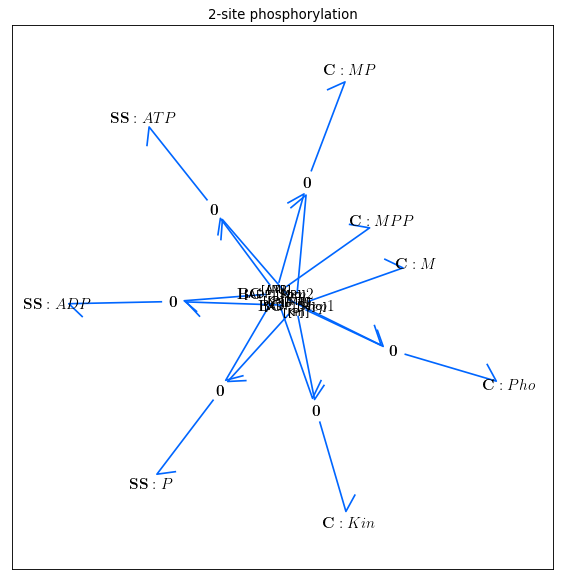

In [23]:
model = MultisitePhosphorylation(n=2)
model.set_params()
bgt.draw(model)
model.constitutive_relations

In [27]:
model.default_params

{('C:Kin', 'k'): 1.0,
 ('C:Pho', 'k'): 1.0,
 ('SS:ATP', 'e'): 19.39984635321688,
 ('SS:ADP', 'e'): 0.0,
 ('SS:P', 'e'): 0.0,
 ('C:M', 'k'): 1.0,
 ('C:MP', 'k'): 16316.353672239,
 ('C:MPP', 'k'): 266223397.1575871}

## A model of the MAPK cascade
Models of multi-site phosphorylation can then be combined into a model of the MAPK cascade. The model can be constructed by first making models of individual "levels" within the cascade and then linking them together. The first level (corresponding to MAPKKK) contains a single phosphorylation site, whereas the two later levels are described by dual phosphorylation chains. The models are coupled together by merging the following components:
- MAPKKKP links the first and second level, and MAPKKPP links the second and third levels, thus they are merged together
- The components corresponding to ATP, ADP and P are merged

For convenience, the components corresponding to the upstream molecule MAPKKKK and output molecule MAPKPP are elevated to the highest level of the model hierarchy.

In [28]:
class MAPK(BondGraph):
    def __init__(self,name="MAPK"):
        level1 = MultisitePhosphorylation(n=1,name="Level 1",K_Kin=1.0)
        level2 = MultisitePhosphorylation(
            n=2,name="Level 2",K_Kin=level1.default_params[('C:MP','k')]
        )
        level3 = MultisitePhosphorylation(
            n=2,name="Level 3",K_Kin=level2.default_params[('C:MPP','k')]
        )
        
        levels = (level1,level2,level3)
        self.levels = levels
        
        BondGraph.__init__(self,name=name,components=(level1,level2,level3))
        
        # Promote input and output molecules
        MKKKK = level1/"C:Kin"
        promote(MKKKK)
        MKKKK.name = "MKKKK"
        
        MKPP = level3/"C:MPP"
        promote(MKPP)
        MKPP.name = "MKPP"
        
        # Merge phosphorylated substrates with kinases on next level of cascade
        MKKKP_components = (level1/"C:MP",level2/"C:Kin")
        unify(MKKKP_components,"MKKKP")
        
        MKKPP_components = (level2/"C:MPP",level3/"C:Kin")
        unify(MKKPP_components,"MKKPP")
        
        # Merge ATP, ADP and P
        energy_sources = ["ATP","ADP","P"]
        for s in energy_sources:
            components = tuple(l/f"SS:{s}" for l in levels)
            unify(components,s)
            
        bgex.set_aqueous_solution_parameters(self,R=1.0,T=1.0)
        
    @property
    def default_params(self):
        level1 = self.levels[0]
        level2 = self.levels[1]
        level3 = self.levels[2]
        params = {
            ("C:MKKKK","k"): level1.default_params[("C:M","k")],
            ("C:MKKKP","k"): level1.default_params[("C:MP","k")],
            ("C:MKKPP","k"): level2.default_params[("C:MPP","k")],
            ("C:MKPP","k"): level3.default_params[("C:MPP","k")],
            ("SS:ATP","e"): level1.default_params[("SS:ATP","e")],
            ("SS:ADP","e"): level1.default_params[("SS:ADP","e")],
            ("SS:P","e"): level1.default_params[("SS:P","e")],
        }
        return params
    
    def set_params(self, params=None):
        for l in self.levels:
            l.set_params()
        
        if not params:
            params = self.default_params
        bgex.set_parameters(self,params)

An instance of the MAPK model can then be created. It has a valid set of differential equations that can be simulated.

[dx_0 + 300*x_0 - 1000*x_18*x_2 - 306441016200029*x_18*x_20/5000000000000000,
 dx_1 + 300*x_1 - 612882032400059*x_2*x_3/10000000000000000 - 1000*x_20*x_3,
 dx_2 - 150*x_0 - 150*x_1 + 1000*x_18*x_2 + 612882032400059*x_2*x_3/10000000000000000,
 dx_3 - 300*x_1 + 612882032400059*x_2*x_3/10000000000000000 + 1000*x_20*x_3,
 dx_4 - 1000*x_20*x_8 - 306441016200029*x_20*x_9/5000000000000000 + 300*x_4,
 dx_5 - 612882032400059*x_10*x_8/10000000000000000 - 1000*x_10*x_9 + 300*x_5,
 dx_6 - 612882032400059*x_20*x_21/10000000000000000 - 1000*x_20*x_9 + 300*x_6,
 dx_7 - 1000*x_10*x_21 - 612882032400059*x_10*x_9/10000000000000000 + 300*x_7,
 dx_8 + 612882032400059*x_10*x_8/10000000000000000 + 1000*x_20*x_8 - 150*x_4 - 150*x_5,
 dx_9 + 25001532205081*x_10*x_9/25000000000 + 25001532205081*x_20*x_9/25000000000 - 150*x_4 - 150*x_5 - 150*x_6 - 150*x_7,
 dx_10 + 1000*x_10*x_21 + 612882032400059*x_10*x_8/10000000000000000 + 25001532205081*x_10*x_9/25000000000 - 300*x_5 - 300*x_7,
 dx_11 + 300*x_11 - 1000*x_15

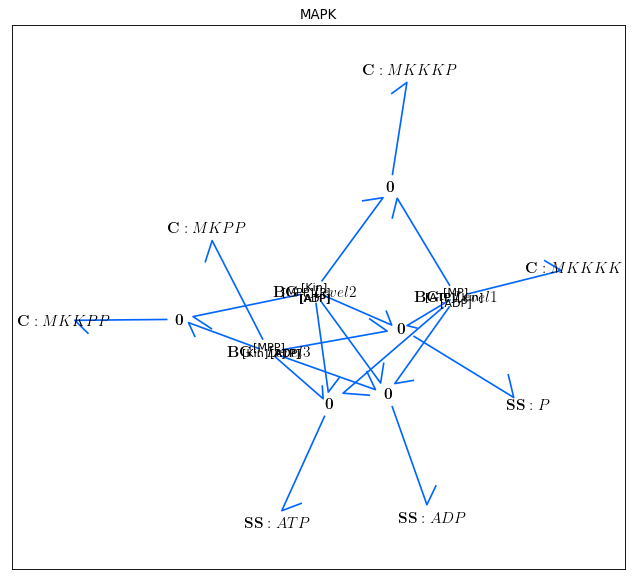

In [29]:
model = MAPK()
model.set_params()
bgt.draw(model)
model.constitutive_relations

In [34]:
from bgt_juliasim import simulate

initial_conditions = {
    model/"C:MKKKK": 3e-5, #Ras
    model/"Level 1"/"C:M": 0.003, #MKKK
    model/"Level 2"/"C:M": 1.2, #MKK
    model/"Level 3"/"C:M": 1.2, #MK
    model/"Level 1"/"C:Pho": 0.0003, #MAPKKK-Pase
    model/"Level 2"/"C:Pho": 0.0003, #MAPKK-Pase
    model/"Level 3"/"C:Pho": 0.12 #MAPK-Pase
}

def make_initial_conditions(model,initial_conditions):
    n_states = len(model.state_vars)
    x0 = np.zeros(n_states)
    for i,state_ref in enumerate(model.state_vars.values()):
        component = bgex.map_state_to_component(*state_ref)
        if component in initial_conditions.keys():
            x0[i] = initial_conditions[component]
            
    return x0

sol = simulate(model,(0.0,100.0),make_initial_conditions(model,initial_conditions))

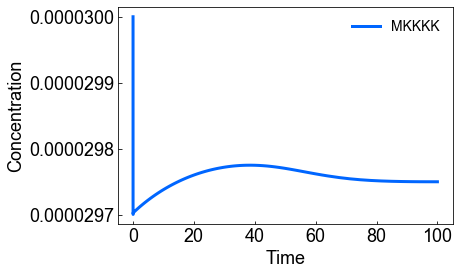

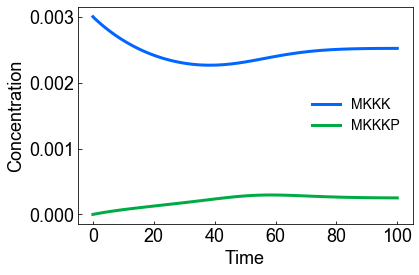

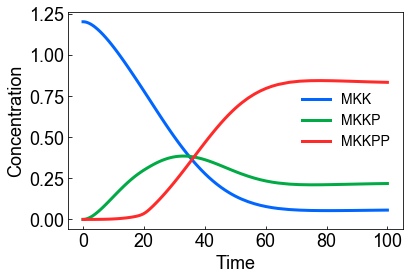

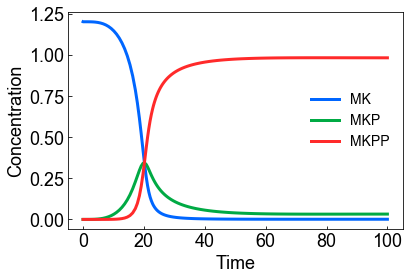

In [35]:
from bgt_extensions import plot_solution
mpl_settings()

def plot_kinases(sol,model):
    plt.figure()
    plot_solution(sol,model,model/"C:MKKKK")
    plt.legend(["MKKKK"])

    plt.figure()
    plot_solution(sol,model,model/"Level 1"/"C:M")
    plot_solution(sol,model,model/"C:MKKKP")
    plt.legend(["MKKK","MKKKP"])

    plt.figure()
    plot_solution(sol,model,model/"Level 2"/"C:M")
    plot_solution(sol,model,model/"Level 2"/"C:MP")
    plot_solution(sol,model,model/"C:MKKPP")
    plt.legend(["MKK","MKKP","MKKPP"])

    plt.figure()
    plot_solution(sol,model,model/"Level 3"/"C:M")
    plot_solution(sol,model,model/"Level 3"/"C:MP")
    plot_solution(sol,model,model/"C:MKPP")
    plt.legend(["MK","MKP","MKPP"])
    
plot_kinases(sol,model)

## Adding feedback
### Positive feedback
A module for positive feedback is created by using an existing module for phosphorylation at a single site, and making minor adjustments to the parameters. This is then composed with the MAPK model through the following operations:
- The MAPKPP species is unified with the kinase of the feedback module
- The MAPKKKK species is unified with the phosphorylated substrate (MP) of the feedback module. This represents the fact that the output catalyses the reaction that increases the pool of available input.
- ATP, ADP and P are unified

In [49]:
class PositiveFeedback(MultisitePhosphorylation):
    def __init__(self,name="Feedback",K_M=1.0,P_factor=P_factor_default,K_Kin=1.0):
        MultisitePhosphorylation.__init__(
            self,n=1,name=name,K_M=K_M,P_factor=P_factor,K_Kin=K_Kin
        )
    
    @property
    def default_params(self):
        params = super().default_params
        
        phosphatase = self.cycles[0].phosphatase
        params[("Step 1/Phosphatase/R:r1","r")] = 10*phosphatase.default_params[("R:r1","r")]
        params[("Step 1/Phosphatase/R:r2","r")] = 10*phosphatase.default_params[("R:r2","r")]
        
        return params
    
class MAPK_PositiveFeedback(BondGraph):
    def __init__(self,name="MAPK with positive feedback"):
        mapk = MAPK()
        
        K_MKKKK = mapk.default_params[("C:MKKKK","k")]
        K_MKKKKI = K_MKKKK/P_factor_default
        self.K_MKKKKI = K_MKKKKI
        K_MKPP = mapk.default_params[("C:MKPP","k")]
        
        feedback = PositiveFeedback(
            name="Feedback",K_M=K_MKKKKI, K_Kin=K_MKPP
        )
        
        self.mapk = mapk
        self.feedback = feedback
        
        BondGraph.__init__(self,name=name,components=(mapk,feedback))
        
        unify((mapk/"C:MKKKK",feedback/"C:MP"),"MKKKK")
        unify((mapk/"C:MKPP",feedback/"C:Kin"),"MKPP")
        unify((mapk/"SS:ATP",feedback/"SS:ATP"),"ATP")
        unify((mapk/"SS:ADP",feedback/"SS:ADP"),"ADP")
        unify((mapk/"SS:P",feedback/"SS:P"),"P")
        
        bgex.set_aqueous_solution_parameters(self,R=1.0,T=1.0)
        
    @property
    def default_params(self):
        mapk = self.mapk
        
        params = {
            ("C:MKKKK","k"): mapk.default_params[("C:MKKKK","k")],
            ("C:MKPP","k"): mapk.default_params[("C:MKPP","k")],
            ("SS:ATP","e"): mapk.default_params[("SS:ATP","e")],
            ("SS:ADP","e"): mapk.default_params[("SS:ADP","e")],
            ("SS:P","e"): mapk.default_params[("SS:P","e")],
        }
        
        return params
    
    def set_params(self, params=None):
        self.mapk.set_params()
        self.feedback.set_params()
        
        if not params:
            params = self.default_params
        bgex.set_parameters(self,params)

In [50]:
model = MAPK_PositiveFeedback()
model.set_params()
model.constitutive_relations

[dx_0 + 300*x_0 - 306441016200029*x_18*x_24/5000000000000000 - 1000*x_2*x_24,
 dx_1 + 300*x_1 - 1000*x_18*x_3 - 612882032400059*x_2*x_3/10000000000000000,
 dx_2 - 150*x_0 - 150*x_1 + 1000*x_2*x_24 + 612882032400059*x_2*x_3/10000000000000000,
 dx_3 - 300*x_1 + 1000*x_18*x_3 + 612882032400059*x_2*x_3/10000000000000000,
 dx_4 - 1000*x_18*x_8 - 306441016200029*x_18*x_9/5000000000000000 + 300*x_4,
 dx_5 - 612882032400059*x_10*x_8/10000000000000000 - 1000*x_10*x_9 + 300*x_5,
 dx_6 - 612882032400059*x_18*x_19/10000000000000000 - 1000*x_18*x_9 + 300*x_6,
 dx_7 - 1000*x_10*x_19 - 612882032400059*x_10*x_9/10000000000000000 + 300*x_7,
 dx_8 + 612882032400059*x_10*x_8/10000000000000000 + 1000*x_18*x_8 - 150*x_4 - 150*x_5,
 dx_9 + 25001532205081*x_10*x_9/25000000000 + 25001532205081*x_18*x_9/25000000000 - 150*x_4 - 150*x_5 - 150*x_6 - 150*x_7,
 dx_10 + 1000*x_10*x_19 + 612882032400059*x_10*x_8/10000000000000000 + 10000612882032400059*x_10*x_9/10000000000000000 - 300*x_5 - 300*x_7,
 dx_11 + 300*x_11

### Negative feedback
A negative feedback loop can also be represented as a phosphorylation event at a single site. This can be composed with the model of MAPK in a similar manner. However, in the case of negative feedback, MAPKKKK is unified with the unphosphorylated substrate (M) of the feedback module so that the output reduces the amount of active input.

In [66]:
class NegativeFeedback(MultisitePhosphorylation):
    def __init__(self,name="Feedback",K_M=1.0,P_factor=P_factor_default,K_Kin=1.0):
        MultisitePhosphorylation.__init__(
            self,n=1,name=name,K_M=K_M,P_factor=P_factor,K_Kin=K_Kin
        )
    
    @property
    def default_params(self):
        params = super().default_params
        
        feedback_strength = 1e-4
        phosphatase = self.cycles[0].phosphatase
        kinase = self.cycles[0].kinase
        
        params = super().default_params
        params[("Step 1/Phosphatase/R:r1","r")] = 1e6*feedback_strength*phosphatase.default_params[("R:r1","r")]
        params[("Step 1/Phosphatase/R:r2","r")] = 1e6*feedback_strength*phosphatase.default_params[("R:r2","r")]
        params[("Step 1/Kinase/R:r1","r")] = feedback_strength*kinase.default_params[("R:r1","r")]
        params[("Step 1/Kinase/R:r2","r")] = feedback_strength*kinase.default_params[("R:r2","r")]
        
        return params
    
class MAPK_NegativeFeedback(BondGraph):
    def __init__(self,name="MAPK with negative feedback"):
        mapk = MAPK()
        
        K_MKKKK = mapk.default_params[("C:MKKKK","k")]
        K_MKPP = mapk.default_params[("C:MKPP","k")]
        
        feedback = NegativeFeedback(
            name="Feedback",K_M=K_MKKKK, K_Kin=K_MKPP
        )
        
        self.mapk = mapk
        self.feedback = feedback
        
        BondGraph.__init__(self,name=name,components=(mapk,feedback))
        
        unify((mapk/"C:MKKKK",feedback/"C:M"),"MKKKK")
        unify((mapk/"C:MKPP",feedback/"C:Kin"),"MKPP")
        unify((mapk/"SS:ATP",feedback/"SS:ATP"),"ATP")
        unify((mapk/"SS:ADP",feedback/"SS:ADP"),"ADP")
        unify((mapk/"SS:P",feedback/"SS:P"),"P")
        
        bgex.set_aqueous_solution_parameters(self,R=1.0,T=1.0)
        
    @property
    def default_params(self):
        mapk = self.mapk
        
        params = {
            ("C:MKKKK","k"): mapk.default_params[("C:MKKKK","k")],
            ("C:MKPP","k"): mapk.default_params[("C:MKPP","k")],
            ("SS:ATP","e"): mapk.default_params[("SS:ATP","e")],
            ("SS:ADP","e"): mapk.default_params[("SS:ADP","e")],
            ("SS:P","e"): mapk.default_params[("SS:P","e")],
        }
        
        return params
    
    def set_params(self, params=None):
        self.mapk.set_params()
        self.feedback.set_params()
        
        if not params:
            params = self.default_params
        bgex.set_parameters(self,params)

In [67]:
model = MAPK_NegativeFeedback()
model.set_params()
model.constitutive_relations

[dx_0 + 300*x_0 - 306441016200029*x_18*x_24/5000000000000000 - 1000*x_2*x_24,
 dx_1 + 300*x_1 - 1000*x_18*x_3 - 612882032400059*x_2*x_3/10000000000000000,
 dx_2 - 150*x_0 - 150*x_1 + 1000*x_2*x_24 + 612882032400059*x_2*x_3/10000000000000000,
 dx_3 - 300*x_1 + 1000*x_18*x_3 + 612882032400059*x_2*x_3/10000000000000000,
 dx_4 - 1000*x_18*x_8 - 306441016200029*x_18*x_9/5000000000000000 + 300*x_4,
 dx_5 - 612882032400059*x_10*x_8/10000000000000000 - 1000*x_10*x_9 + 300*x_5,
 dx_6 - 612882032400059*x_18*x_19/10000000000000000 - 1000*x_18*x_9 + 300*x_6,
 dx_7 - 1000*x_10*x_19 - 612882032400059*x_10*x_9/10000000000000000 + 300*x_7,
 dx_8 + 612882032400059*x_10*x_8/10000000000000000 + 1000*x_18*x_8 - 150*x_4 - 150*x_5,
 dx_9 + 25001532205081*x_10*x_9/25000000000 + 25001532205081*x_18*x_9/25000000000 - 150*x_4 - 150*x_5 - 150*x_6 - 150*x_7,
 dx_10 + 1000*x_10*x_19 + 612882032400059*x_10*x_8/10000000000000000 + 10000612882032400059*x_10*x_9/10000000000000000 - 300*x_5 - 300*x_7,
 dx_11 + 300*x_11